# Processing a 4ake trajectory #

In this experiment we showcase how the tools from Riemannian geometry help us understand protein data sets. In particular, we want to show how 
* having a suitable notion of distance is useful in computing a natural mean of the data
* having a logarithmic mappings is useful in dimension reduction and having an exponential mapping is useful for visualizing the subspace
* having geodesics under a suitable Riemannian metric can preserve important features of the data

In [1]:
import mdtraj as md
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import sys

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.autolayout': True})
    
from src.manifolds.pointcloud import PointCloud

In [2]:
results_folder = os.path.join(os.getcwd(), "results")
print(results_folder)

/Users/wdiepeveen/Documents/PhD/Projects/7 - Manifold-based Protein Deformations/src/Manifold-based-Protein-Deformations/experiments/results


## Load data ##

In [3]:
struct = 2

wd = ".."
data_folder = os.path.join("data", "molecular_dynamics")

if struct == 1:
    trajectory_path = os.path.join(wd, data_folder, "4ake", "dims0001_fit-core.dcd")
    topology_path = os.path.join(wd, data_folder, "4ake", "adk4ake.psf")
    results_folder = os.path.join(results_folder, "4ake")
    fig_prefix = "4ake"
    bbox = 20
elif struct == 2:
    trajectory_path = os.path.join(wd, data_folder, "covid_spike", "MDtraj_sarscov_2.dcd")
    topology_path = os.path.join(wd, data_folder, "covid_spike", "DESRES-Trajectory_sarscov2-12212688-5-2-no-water.pdb")
    results_folder = os.path.join(results_folder, "covid_spike")
    fig_prefix = "covid_spike"
    bbox = 40

t = md.load(trajectory_path, top = topology_path)

# get Calpha positions
indices = []

for m in t.topology.atoms_by_name('CA'):
    indices.append(m.index)
    
ca_pos = 10 * torch.tensor(t.xyz[:,indices,:])
# if struct == 2:
#     ca_pos = ca_pos[0:-1:2]

In [4]:
# construct manifold
num_proteins = ca_pos.shape[0] 
print(num_proteins)
protein_len = ca_pos.shape[1]
manifold = PointCloud(3, protein_len, base=ca_pos[0], alpha=1.)
# constuct rotation matrix
rot_xz = torch.zeros(3,3)
rot_xz[2,0] = 1.
rot_xz[1,1] = 1.
rot_xz[0,2] = -1.
manifold.base_point = torch.einsum("ba,ia->ib", rot_xz, manifold.base_point)
rot_xy = torch.zeros(3,3)
theta = torch.tensor([- torch.pi * 1/3])
rot_xy[0,0] = torch.cos(theta)
rot_xy[0,1] = - torch.sin(theta)
rot_xy[1,0] = torch.sin(theta)
rot_xy[1,1] = torch.cos(theta)
rot_xy[2,2] = 1.
manifold.base_point = torch.einsum("ba,ia->ib", rot_xy, manifold.base_point)

200


In [5]:
# align all proteins with base
proteins = manifold.align_mpoint(ca_pos[None], base=manifold.base_point).squeeze()

## Separation-geodesic interpolating ##

In [6]:
t_steps = 21
p0 = proteins[0]
p1 = proteins[-1]
T = torch.linspace(0,1,t_steps) # torch.tensor([1/4,1/2,3/4]) # torch.tensor([1/2])
pt = torch.zeros(t_steps, protein_len, 3)
mdt = torch.zeros(t_steps, protein_len, 3)
for i,t in enumerate(T):
    print(f"computing geodesic {i+1}")
    md_ind = int(i/(t_steps-1) * (num_proteins-1))
    pt[i] = manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([t]), debug=True).squeeze()
    mdt[i] = proteins[md_ind]
    
%timeit manifold.s_geodesic(p0[None,None], p1[None,None], torch.tensor([T[int(t_steps/2)]]))

computing geodesic 1
1 | relerror = 1.033305048942566
2 | relerror = 0.4358671307563782
3 | relerror = 0.15209271013736725
4 | relerror = 0.057526037096977234
5 | relerror = 0.03480946645140648
6 | relerror = 0.005996909458190203
7 | relerror = 8.056004298850894e-05
computing geodesic 2
1 | relerror = 0.979174792766571
2 | relerror = 0.3946484327316284
3 | relerror = 0.1287967562675476
4 | relerror = 0.05257176607847214
5 | relerror = 0.03898681327700615
6 | relerror = 0.017359962686896324
7 | relerror = 0.001624846481718123
8 | relerror = 2.8781709261238575e-05
computing geodesic 3
1 | relerror = 0.9252090454101562
2 | relerror = 0.35714229941368103
3 | relerror = 0.10780401527881622
4 | relerror = 0.046781398355960846
5 | relerror = 0.036836858838796616
6 | relerror = 0.033433809876441956
7 | relerror = 0.008970379829406738
8 | relerror = 0.000602319254539907
computing geodesic 4
1 | relerror = 0.8707449436187744
2 | relerror = 0.32284754514694214
3 | relerror = 0.08982144296169281
4

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

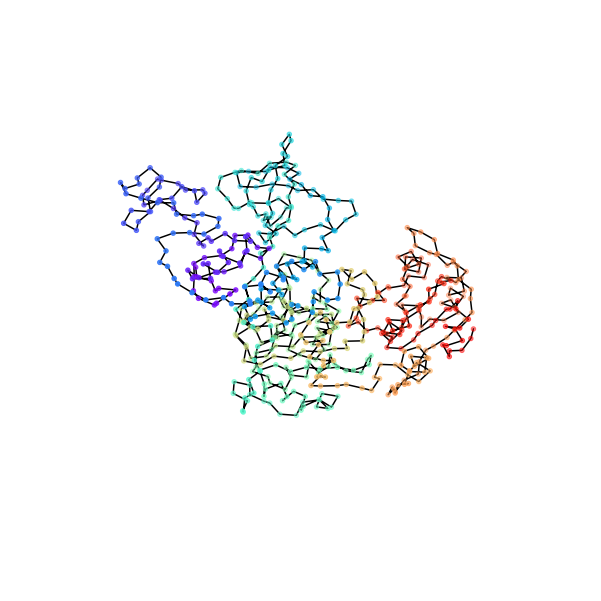

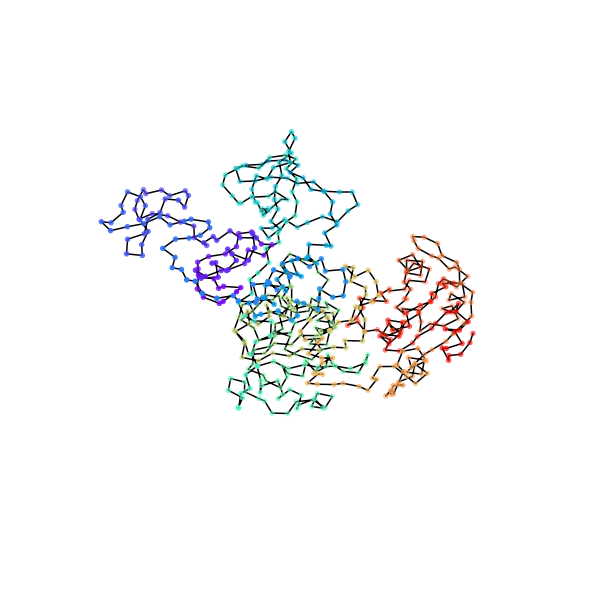

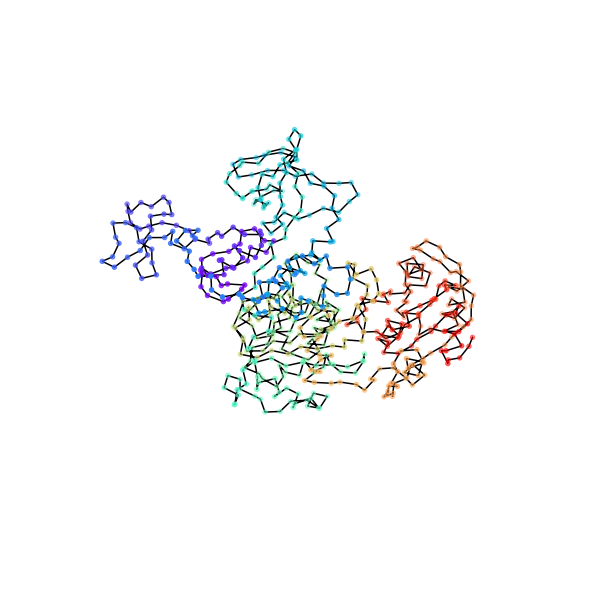

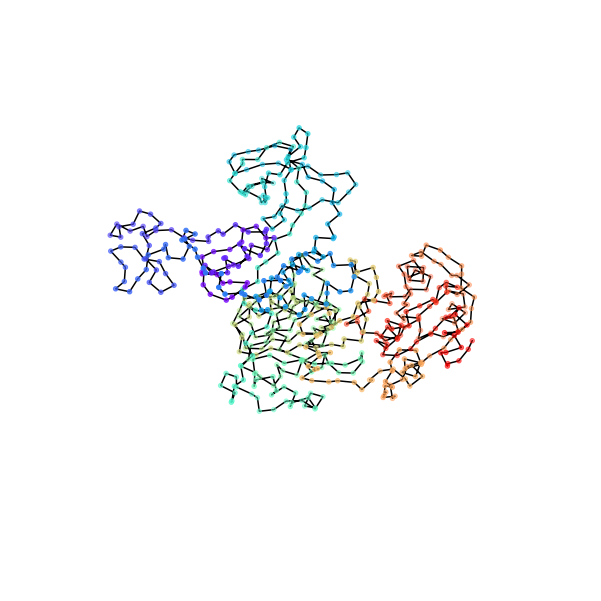

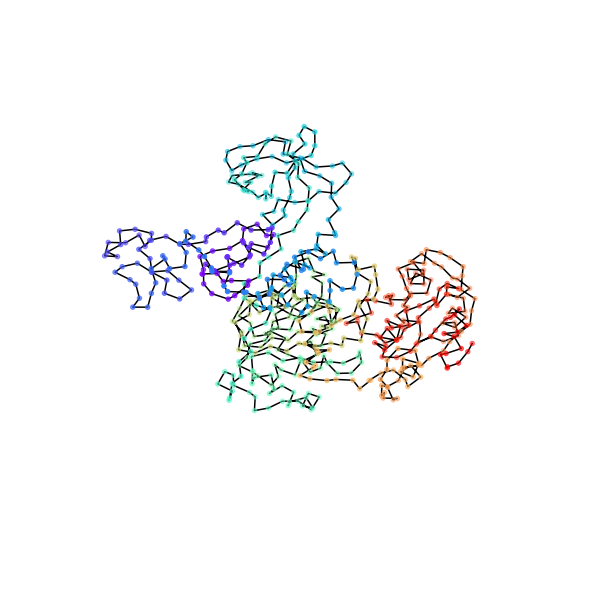

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

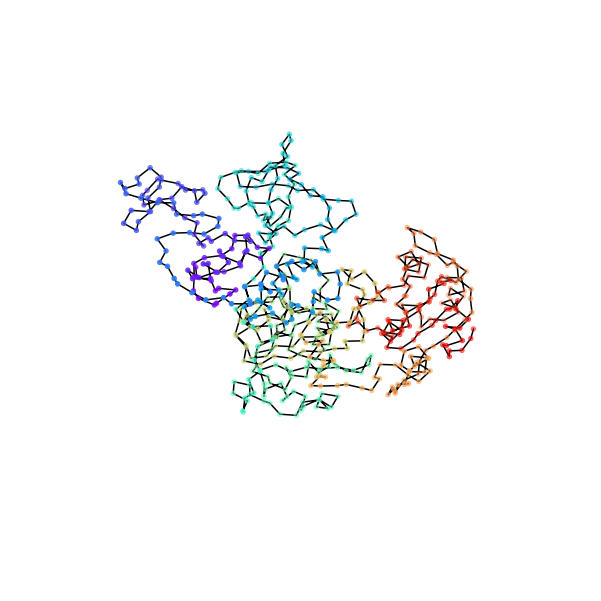

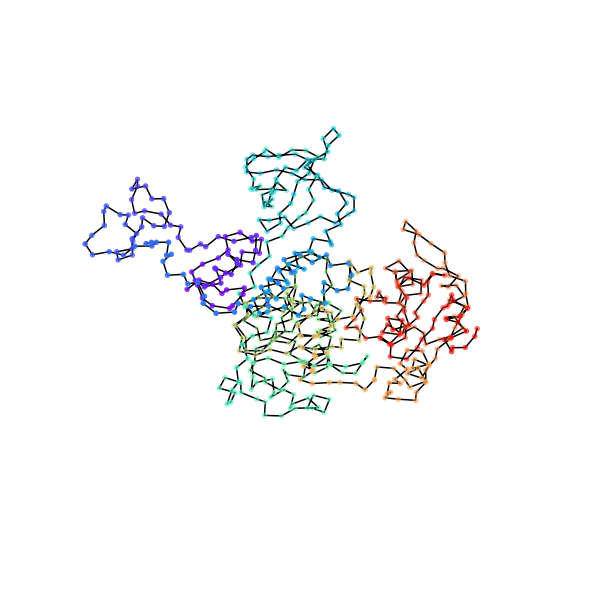

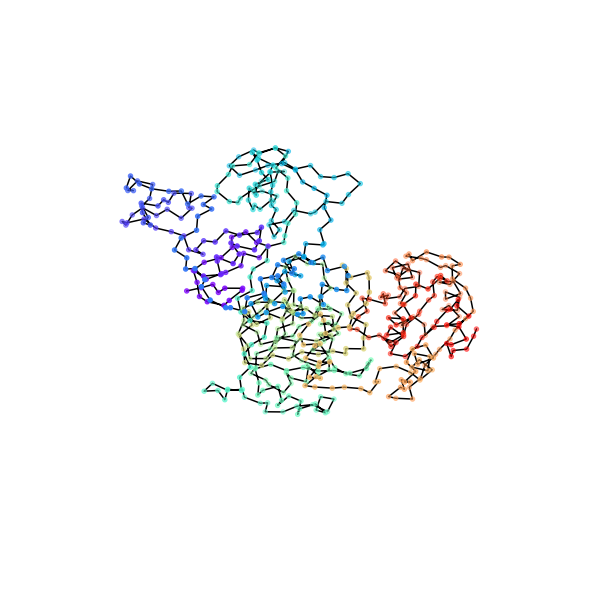

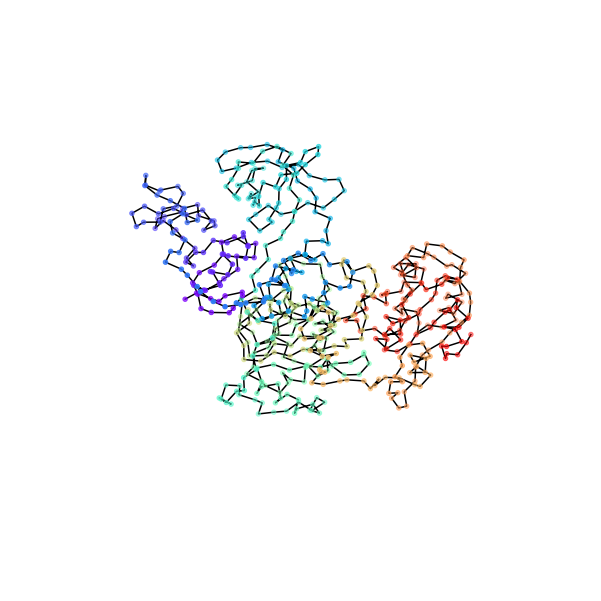

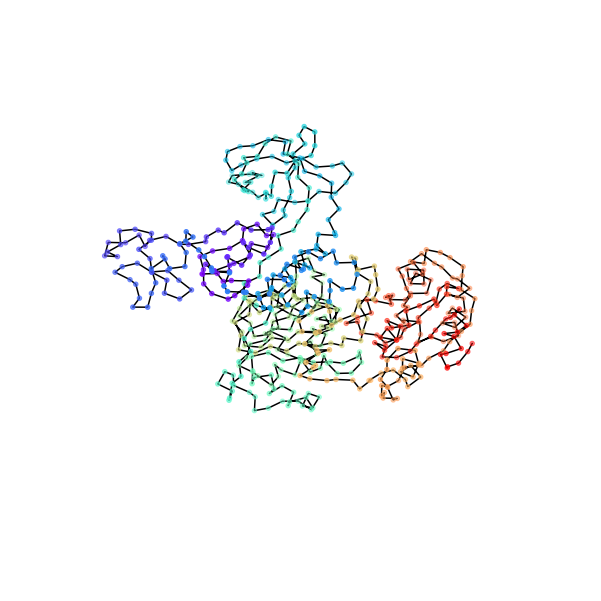

In [24]:
# Plot 
formt = '.png'
num_figs = 5
fig_size = 31 * (protein_len/214) ** (1/3) # cm

for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    fig = plt.figure(figsize=(fig_size/5, fig_size/5))
    ax = plt.axes(projection='3d')
    ax.plot3D(pt[g_ind,:,0],pt[g_ind,:,1],pt[g_ind,:,2], 'black')
    ax.scatter(pt[g_ind,:,0],pt[g_ind,:,1],pt[g_ind,:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    ax.axes.set_xlim3d(left=-bbox, right=bbox) 
    ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
    ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
    ax.set_axis_off() 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_{g_ind}f{t_steps-1}_geo'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()


for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    md_ind = int(i/(num_figs-1) * (num_proteins-1))
    fig = plt.figure(figsize=(fig_size/5, fig_size/5))
    ax = plt.axes(projection='3d')
    ax.plot3D(mdt[g_ind,:,0],mdt[g_ind,:,1],mdt[g_ind,:,2], 'black')
    ax.scatter(mdt[g_ind,:,0],mdt[g_ind,:,1],mdt[g_ind,:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    ax.axes.set_xlim3d(left=-bbox, right=bbox) 
    ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
    ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
    ax.set_axis_off() 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_{g_ind}f{t_steps-1}_md_{md_ind}'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

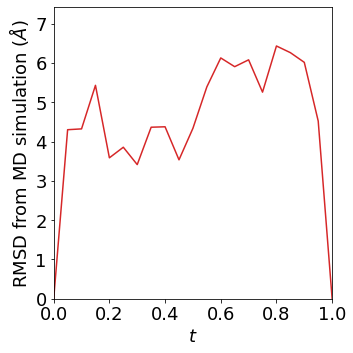

In [25]:
# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T = torch.sqrt(torch.sum((pt - mdt) ** 2,[1,2]) / protein_len)

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/4, fig_size/4))
plt.plot(T, rmsd_T, 'tab:red')
plt.xlim([0,1])
plt.ylim([0,rmsd_T.max()+1])
plt.xlabel(r'$t$')
plt.ylabel(r'RMSD from MD simulation ($\AA$)')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_md'+formt))
plt.show


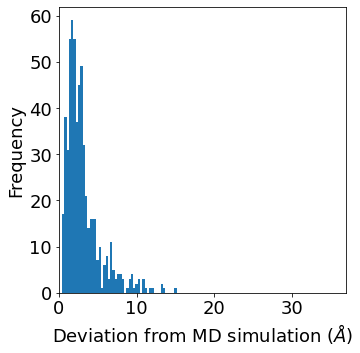

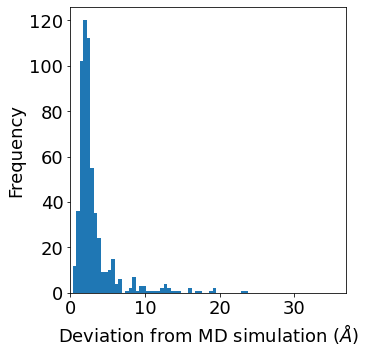

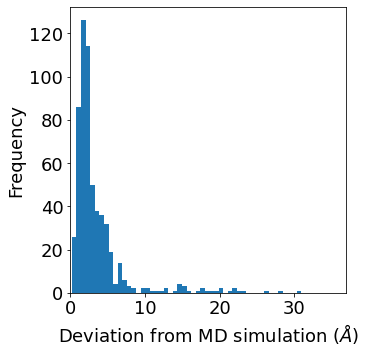

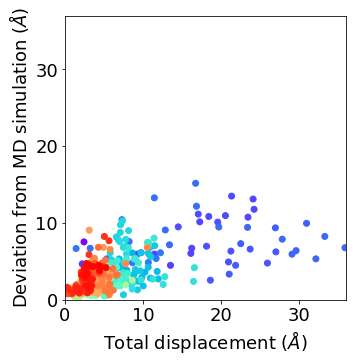

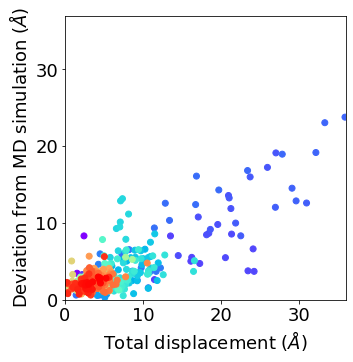

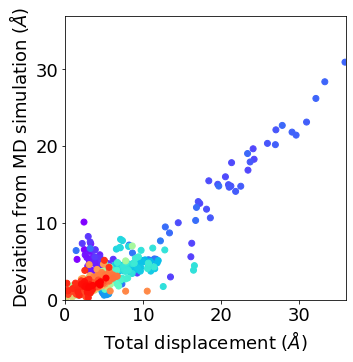

In [26]:
d_T = torch.sqrt(torch.sum((pt - mdt) ** 2, -1))
d_total = torch.sqrt(torch.sum((proteins[0] - proteins[-1]) ** 2, -1))

max_error = int(torch.max(d_T)) + 1
max_displacement = int(torch.max(d_total)) + 1

num_figs = 3
fig_size = 21 # cm
for i in range(num_figs):
    g_ind = int((i+1)/(num_figs+1) * (t_steps-1))
    ax = plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.hist(d_T[g_ind][None], bins=50)
    plt.xlim([0, max_error])
    plt.ylabel('Frequency')
    plt.xlabel(r'Deviation from MD simulation ($\AA$)')
plt.show()

# fig = plt.figure(figsize=(fig_size, fig_size/num_figs))
for i in range(num_figs):
    g_ind = int((i+1)/(num_figs+1) * (t_steps-1))
    md_ind = int((i+1)/(num_figs+1) * (num_proteins-1))
    plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.scatter(d_total,d_T[g_ind], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    plt.ylim([0, max_error])
    plt.xlim([0, max_displacement])
    plt.xlabel(r'Total displacement ($\AA$)')
    plt.ylabel(r'Deviation from MD simulation ($\AA$)')
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_displacement_vs_error_{g_ind}f{t_steps-1}_md_{md_ind}'+formt))
plt.show()

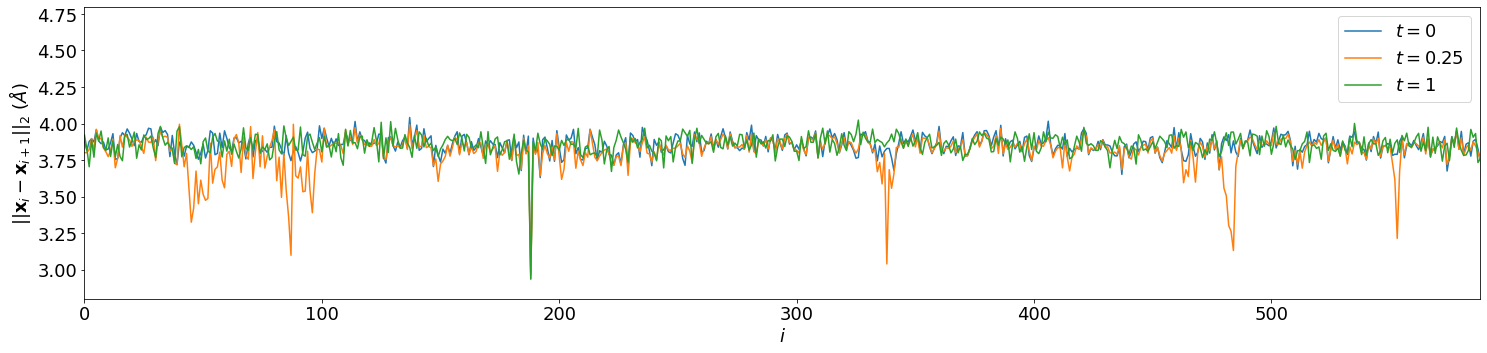

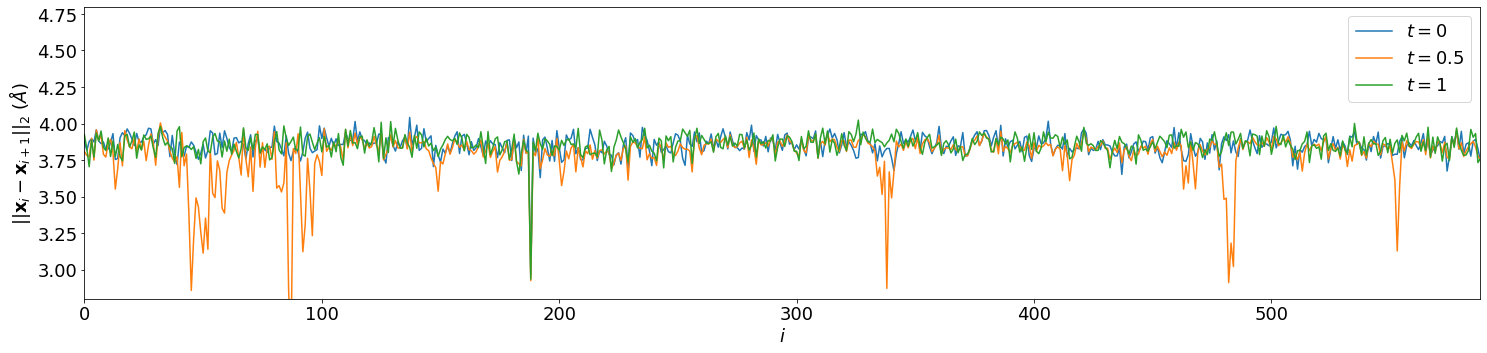

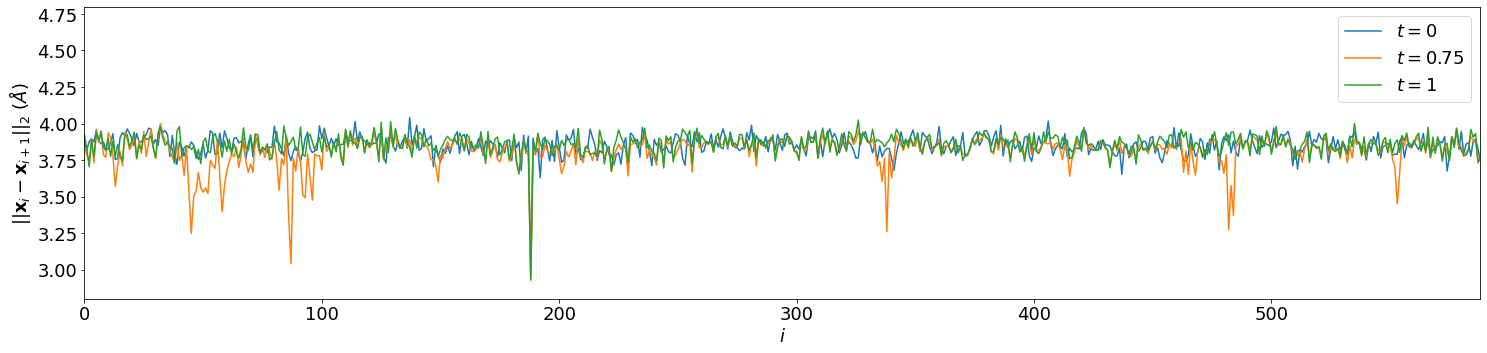

In [27]:
pt_pairwise_distances = manifold.pairwise_distances(pt[None]).squeeze()
pt_adj_pairwise_distances = torch.diagonal(pt_pairwise_distances,offset=1, dim1=1, dim2=2)

num_figs = 3
fig_size = 21 # cm

for i in range(num_figs):
    plt.figure(figsize=(fig_size, fig_size/4))
    g_ind = int((i+1)/(num_figs+1) * (t_steps-1))
    plt.plot(range(protein_len-1), torch.sqrt(pt_adj_pairwise_distances[0]), label=r'$t=0$')
    plt.plot(range(protein_len-1), torch.sqrt(pt_adj_pairwise_distances[g_ind]), label=r'$t=$' +f'{T[g_ind]}')
    plt.plot(range(protein_len-1), torch.sqrt(pt_adj_pairwise_distances[-1]), label=r'$t=1$')
    plt.xlim([0, protein_len-2])
    plt.ylim([2.8,4.8])
    plt.ylabel(r'$\|\|\mathbf{x}_i - \mathbf{x}_{i+1}\|\|_2$ ($\AA$)')
    plt.xlabel(r'$i$')
    plt.legend()
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_adjacent_residue_{g_ind}f{t_steps-1}'+formt)) 
plt.show()

## Separation-barycentre of the trajectory ##

In [11]:
p_barycentre = manifold.s_mean(proteins[None], x0=proteins[int(num_proteins/2)][None,None], debug=True).squeeze()
%timeit manifold.s_mean(proteins[None], x0=proteins[int(num_proteins/2)][None,None]).squeeze()

1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.000310569244902581
1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.000310569244902581
1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.000310569244902581
1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.000310569244902581
1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.000310569244902581
1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.000310569244902581
1 | relerror = 0.046722039580345154
2 | relerror = 0.013430837541818619
3 | relerror = 0.0011204314650967717
4 | relerror = 0.0003

In [12]:
p_barycentre_pairwise_distances = manifold.pairwise_distances(p_barycentre[None,None]).squeeze()
p_barycentre_adj_pairwise_distances = torch.diagonal(p_barycentre_pairwise_distances,1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

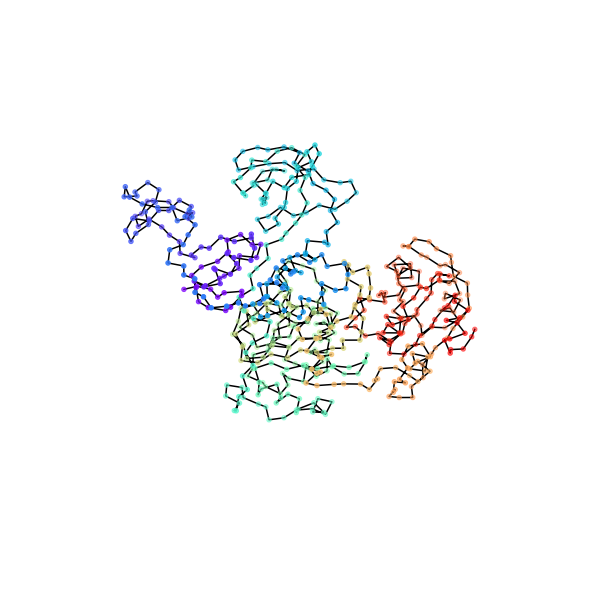

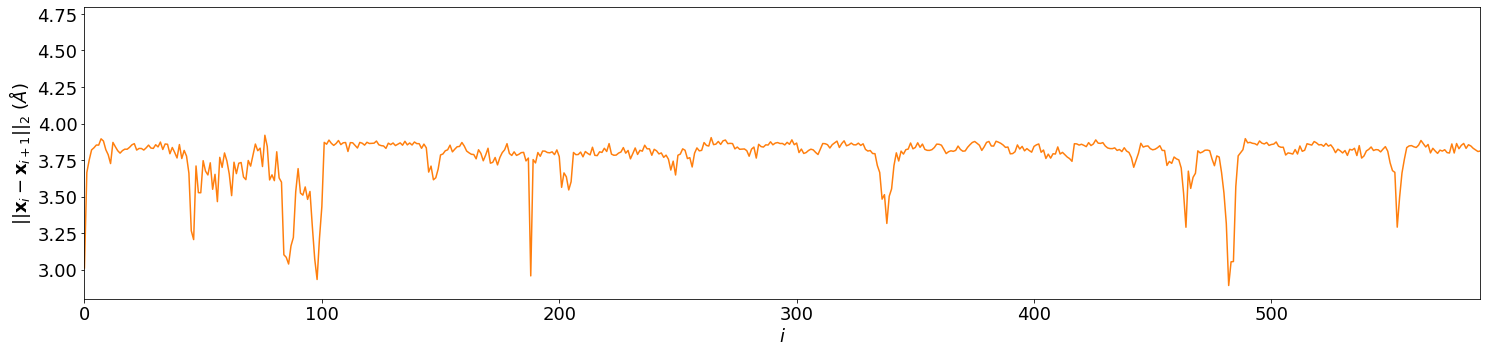

In [28]:
fig_size = 31 * (protein_len/214) ** (1/3) # cm

fig = plt.figure(figsize=(fig_size/5, fig_size/5))
ax = plt.axes(projection='3d')
ax.plot3D(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], 'black')
ax.scatter(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
ax.axes.set_xlim3d(left=-bbox, right=bbox) 
ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
ax.set_axis_off() 
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(os.path.join(results_folder,f'4ake_barycentre'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

fig_size = 21 # cm
plt.figure(figsize=(fig_size, fig_size/4))
plt.plot(range(protein_len-1), torch.sqrt(p_barycentre_adj_pairwise_distances), color='tab:orange')
plt.xlim([0, protein_len-2])
plt.ylim([2.8,4.8])
plt.ylabel(r'$\|\|\mathbf{x}_i - \mathbf{x}_{i+1}\|\|_2$ ($\AA$)')
plt.xlabel(r'$i$')
# save figure
# extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(os.path.join(results_folder,fig_prefix +f'_adjacent_residue_barycentre'+formt)) 
plt.show()

## Separation-logarithmic map for low rank approximation ##

In [14]:
# compute logs to all points from pt
log_p_barycentre = manifold.s_log(p_barycentre[None,None], proteins[None]).squeeze()
%timeit manifold.s_log(p_barycentre[None,None], proteins[None]).squeeze()

1.69 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


tensor([2.9290e+00, 3.9210e+01, 4.0794e+01, 4.1646e+01, 4.3881e+01, 4.3885e+01,
        4.4882e+01, 4.6334e+01, 4.8398e+01, 4.9913e+01, 5.0747e+01, 5.1474e+01,
        5.2510e+01, 5.3350e+01, 5.3419e+01, 5.4627e+01, 5.5847e+01, 5.6347e+01,
        5.7015e+01, 5.8714e+01, 5.9312e+01, 6.0480e+01, 6.2589e+01, 6.3676e+01,
        6.5228e+01, 6.6601e+01, 6.7102e+01, 6.8287e+01, 6.8596e+01, 7.0742e+01,
        7.2591e+01, 7.4612e+01, 7.5471e+01, 7.6498e+01, 7.6594e+01, 8.0116e+01,
        8.0349e+01, 8.2098e+01, 8.3476e+01, 8.4108e+01, 8.5380e+01, 8.8127e+01,
        8.8959e+01, 9.0432e+01, 9.1026e+01, 9.2001e+01, 9.4393e+01, 9.6092e+01,
        9.7123e+01, 9.7797e+01, 1.0019e+02, 1.0190e+02, 1.0190e+02, 1.0434e+02,
        1.0514e+02, 1.0869e+02, 1.0958e+02, 1.1020e+02, 1.1187e+02, 1.1270e+02,
        1.1522e+02, 1.1743e+02, 1.2009e+02, 1.2016e+02, 1.2288e+02, 1.2422e+02,
        1.2594e+02, 1.2929e+02, 1.3012e+02, 1.3308e+02, 1.3561e+02, 1.3793e+02,
        1.3963e+02, 1.4296e+02, 1.4670e+

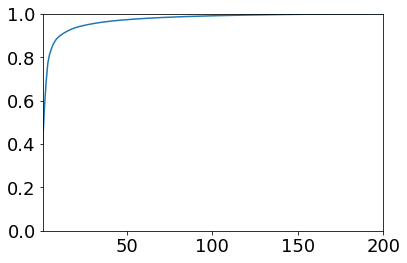

In [15]:
# compute gramm matrix
# Gramm_mat = manifold.inner(p_barycentre[None,None], log_p_barycentre[None,None],log_p_barycentre[None,None]).squeeze()
Gramm_mat = torch.einsum("Nia,Mia->NM",log_p_barycentre,log_p_barycentre)
L, U = torch.linalg.eigh(Gramm_mat)
R_p_barycentre = torch.einsum("NM,Nia->Mia", U, log_p_barycentre)

# print eigenvalues
print(L)
th = 0.85
rank = int(torch.linspace(1,len(L),len(L))[L.flip(0).cumsum(0)/L.sum() > th].min())
print(rank)

plt.figure()
plt.plot(torch.linspace(1,len(L),len(L)), L.flip(0).cumsum(0)/L.sum())
plt.xlim([1, len(L)])
plt.ylim([0, 1])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

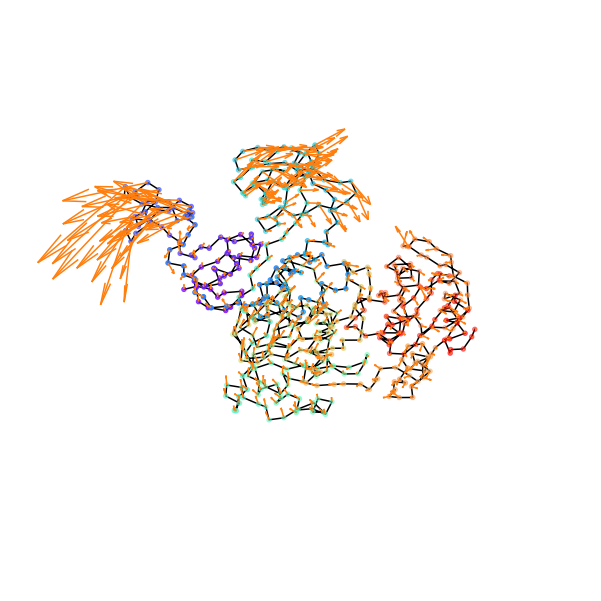

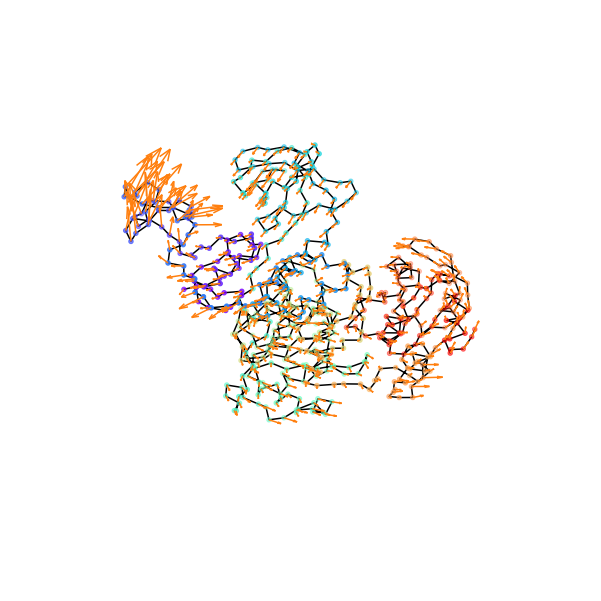

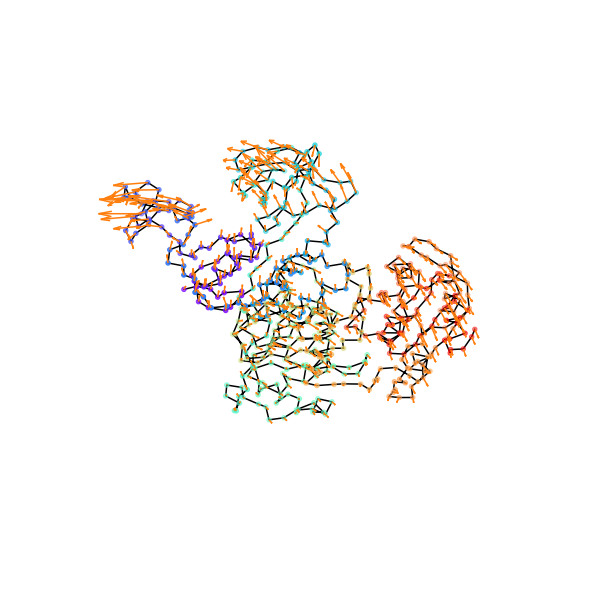

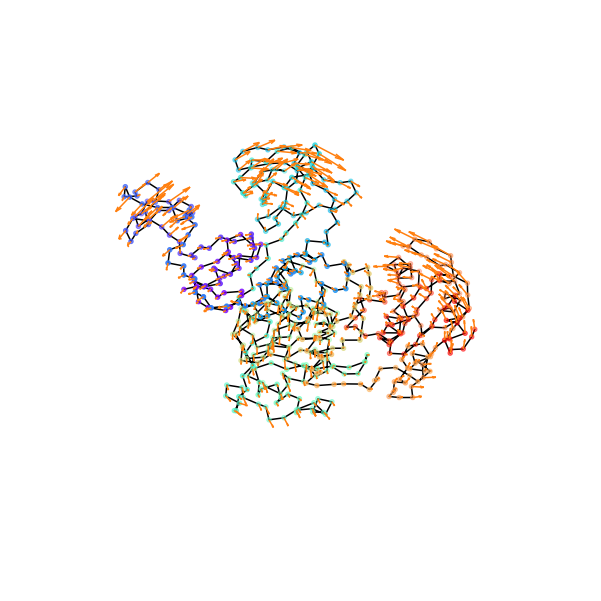

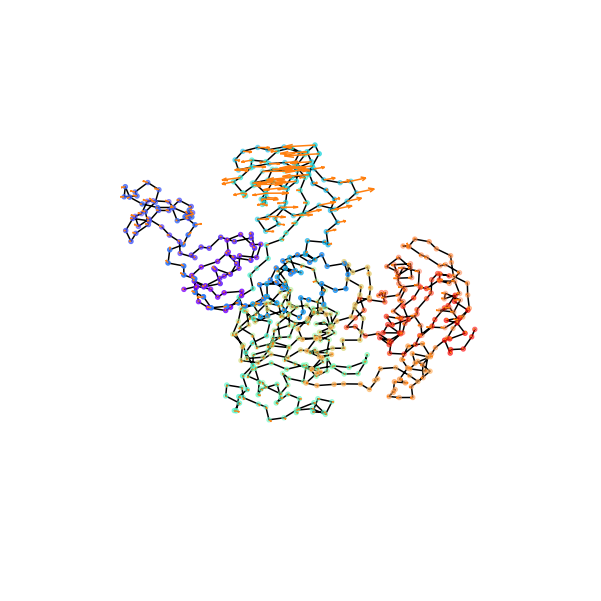

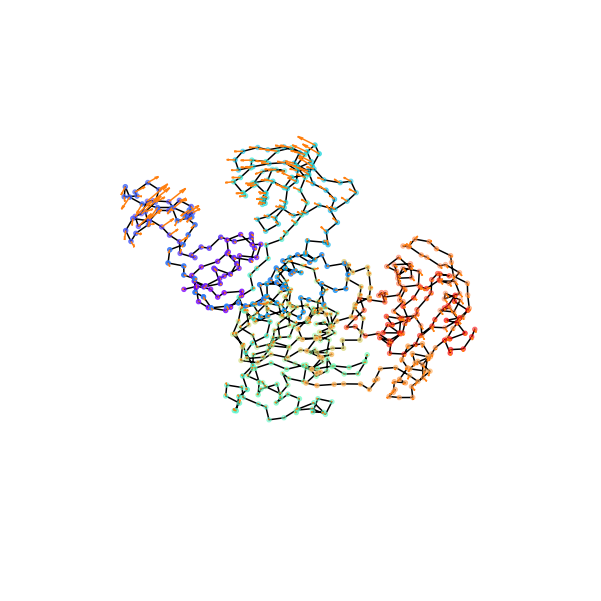

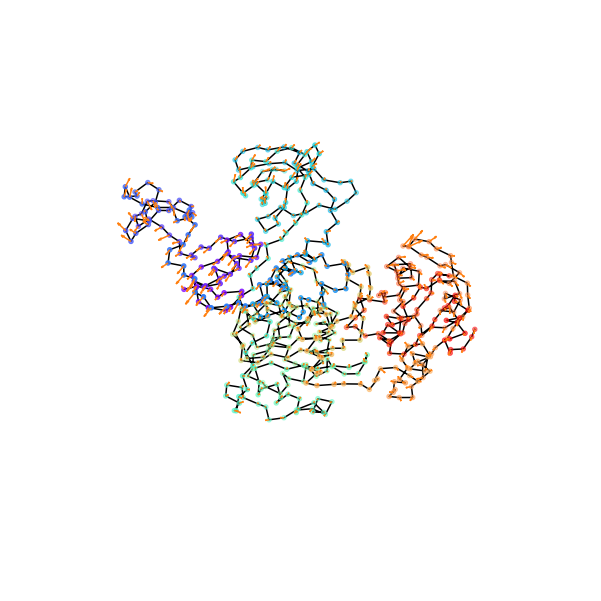

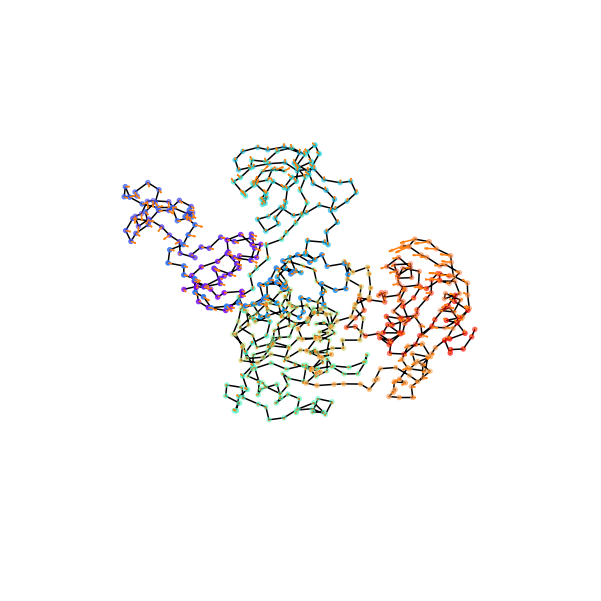

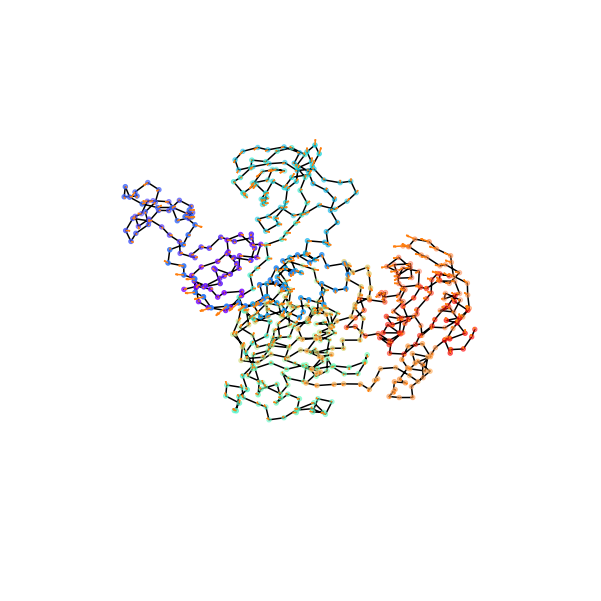

In [29]:
s = 0.2
fig_size = 31 * (protein_len/214) ** (1/3) # cm
num_figs = rank +2
for i in range(num_figs):
    plt.figure(figsize=(fig_size/5, fig_size/5))
    ax = plt.axes(projection='3d')
    ax.plot3D(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], 'black')
    ax.scatter(p_barycentre[:,0], p_barycentre[:,1], p_barycentre[:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    ax.quiver(p_barycentre[:, 0], p_barycentre[:, 1], p_barycentre[:, 2], s * R_p_barycentre[-(i+1),:, 0], s * R_p_barycentre[-(i+1),:, 1], s * R_p_barycentre[-(i+1),:, 2],color='tab:orange')
    ax.axes.set_xlim3d(left=-bbox, right=bbox) 
    ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
    ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
    ax.set_axis_off() 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_barycentre_tvector_{i}'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

In [17]:
log_p_barycentre_r = torch.einsum("Mia,NM->Nia", R_p_barycentre[num_proteins-rank:num_proteins],U[:,num_proteins-rank:num_proteins])

log_p_barycentre_t = torch.zeros(t_steps, protein_len, 3)
log_p_barycentre_t_r = torch.zeros(t_steps, protein_len, 3)
mdt_r = torch.zeros(t_steps, protein_len, 3)
for i in range(t_steps):
    md_ind = int(i/(t_steps-1) * (num_proteins-1))
    print(f"computing approximation of protein {md_ind}")
    log_p_barycentre_t[i] = log_p_barycentre[md_ind]
    log_p_barycentre_t_r[i] = log_p_barycentre_r[md_ind]
    mdt_r[i] = manifold.s_exp(p_barycentre[None,None], log_p_barycentre_r[md_ind][None,None], c=1/4, step_size=1., debug=True).squeeze()
%timeit manifold.s_exp(p_barycentre[None,None], log_p_barycentre_r[md_ind][None,None], c=1/4, step_size=1.).squeeze()

computing approximation of protein 0
computing exp in 6 steps
1 | relerror = 1.0298082828521729
2 | relerror = 0.06209982931613922
3 | relerror = 0.00010989250586135313
1 | relerror = 1.029667615890503
2 | relerror = 0.06043427437543869
3 | relerror = 0.00011092674685642123
1 | relerror = 1.0293985605239868
2 | relerror = 0.059228990226984024
3 | relerror = 0.00011401434312574565
1 | relerror = 1.029079794883728
2 | relerror = 0.05852710083127022
3 | relerror = 0.00012137978046666831
1 | relerror = 1.0288256406784058
2 | relerror = 0.05830137059092522
3 | relerror = 0.00012875061656814069
computing approximation of protein 9
computing exp in 5 steps
1 | relerror = 0.9954327940940857
2 | relerror = 0.06981300562620163
3 | relerror = 0.00029638988780789077
1 | relerror = 1.0006109476089478
2 | relerror = 0.07255570590496063
3 | relerror = 0.00031447107903659344
1 | relerror = 1.005571961402893
2 | relerror = 0.07438725233078003
3 | relerror = 0.0003309187013655901
1 | relerror = 1.010117

2 | relerror = 0.0360206663608551
3 | relerror = 9.192115248879418e-05
1 | relerror = 1.012146234512329
2 | relerror = 0.0337001271545887
3 | relerror = 8.097475074464455e-05
1 | relerror = 1.0111522674560547
2 | relerror = 0.031926240772008896
3 | relerror = 7.440172339556739e-05
1 | relerror = 1.010077953338623
2 | relerror = 0.03073113039135933
3 | relerror = 7.3270384746138e-05
1 | relerror = 1.008960247039795
2 | relerror = 0.03016951121389866
3 | relerror = 8.159145363606513e-05
1 | relerror = 1.0078601837158203
2 | relerror = 0.030334649607539177
3 | relerror = 0.00010119349462911487
computing approximation of protein 149
computing exp in 5 steps
1 | relerror = 1.0111311674118042
2 | relerror = 0.0363037995994091
3 | relerror = 0.00013490051787812263
1 | relerror = 1.0111396312713623
2 | relerror = 0.033747151494026184
3 | relerror = 0.00011751304555218667
1 | relerror = 1.0110101699829102
2 | relerror = 0.03179936110973358
3 | relerror = 0.00010826514335349202
1 | relerror = 1.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  

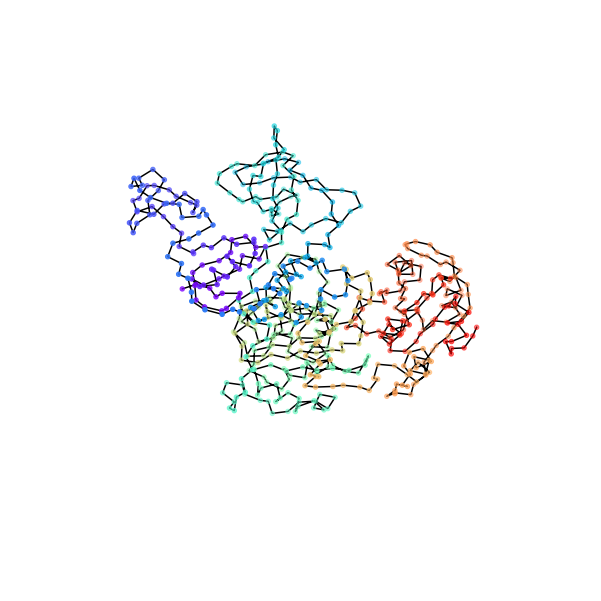

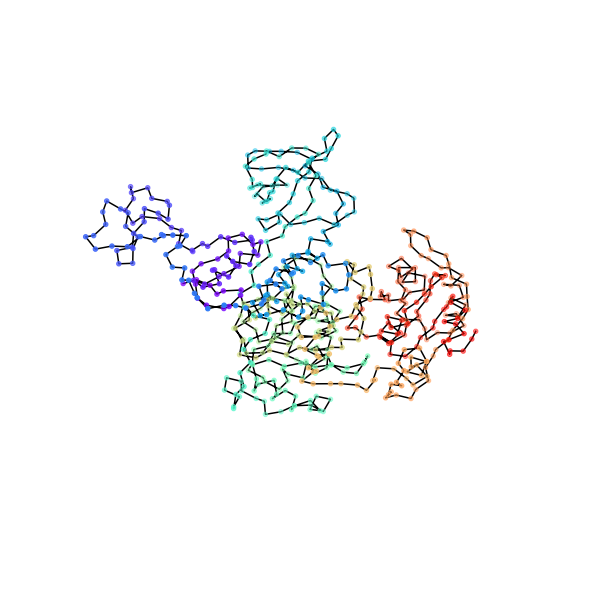

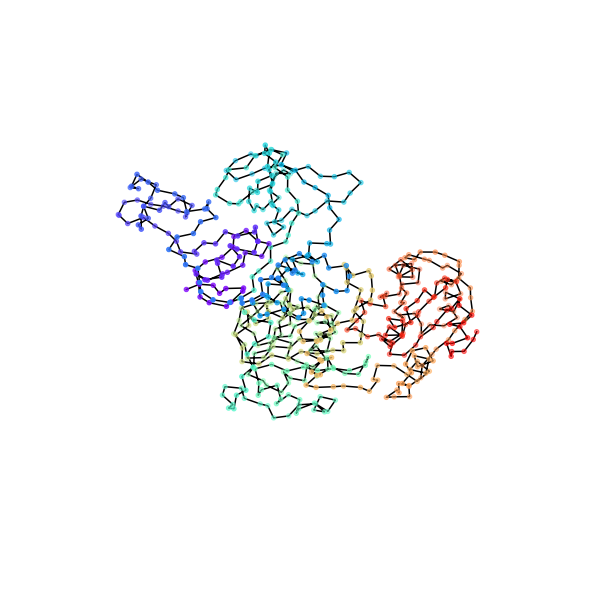

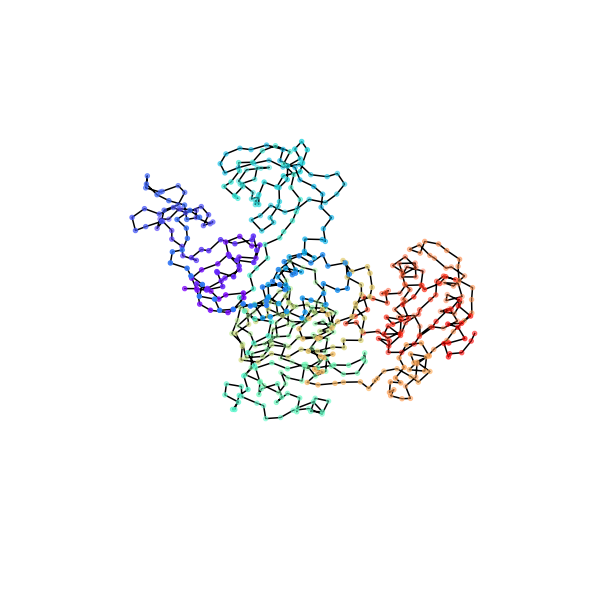

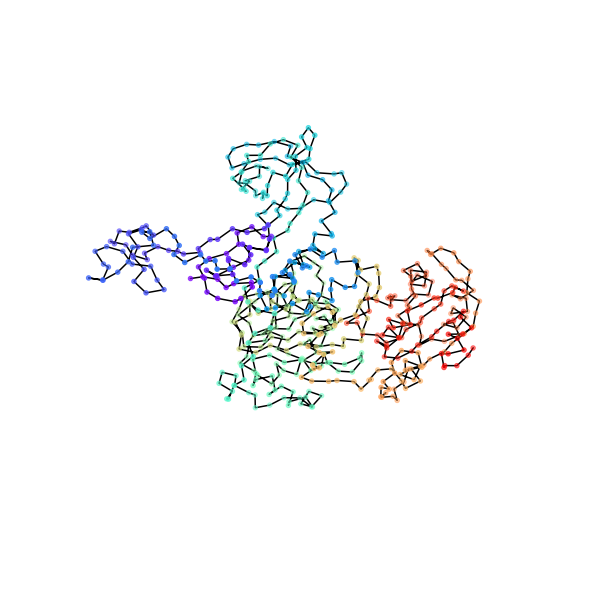

<function matplotlib.pyplot.show(close=None, block=None)>

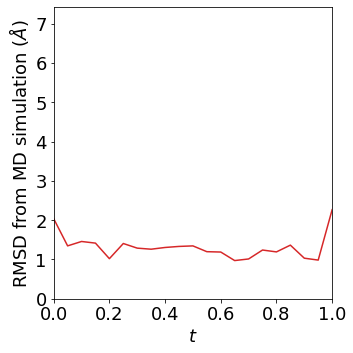

In [30]:
fig_size = 31 * (protein_len/214) ** (1/3) # cm
num_figs=5
for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    md_ind = int(i/(num_figs-1) * (num_proteins-1))
    fig = plt.figure(figsize=(fig_size/5, fig_size/5))
    ax = plt.axes(projection='3d')
    ax.plot3D(mdt_r[g_ind,:,0],mdt_r[g_ind,:,1],mdt_r[g_ind,:,2], 'black')
    ax.scatter(mdt_r[g_ind,:,0],mdt_r[g_ind,:,1],mdt_r[g_ind,:,2], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    ax.axes.set_xlim3d(left=-bbox, right=bbox) 
    ax.axes.set_ylim3d(bottom=-bbox, top=bbox) 
    ax.axes.set_zlim3d(bottom=-bbox, top=bbox) 
    ax.set_axis_off() 
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_rank_{rank}_{g_ind}f{t_steps-1}_md_{md_ind}'+formt), bbox_inches=extent.expanded(0.8, 0.8))
plt.show()

# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T_r = torch.sqrt(torch.sum((mdt_r - mdt) ** 2,[1,2]) / protein_len)

# scatter plot 

fig_size = 21 # cm
plt.figure(figsize=(fig_size/4, fig_size/4))
plt.plot(T, rmsd_T_r, 'tab:red')
plt.xlim([0,1])
plt.ylim([0,rmsd_T.max()+1])
plt.xlabel(r'$t$')
plt.ylabel(r'RMSD from MD simulation ($\AA$)')
# save figure
# extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_rank_{rank}'+formt))
plt.show

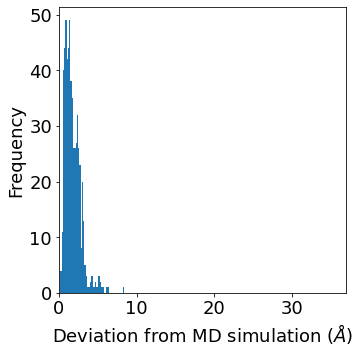

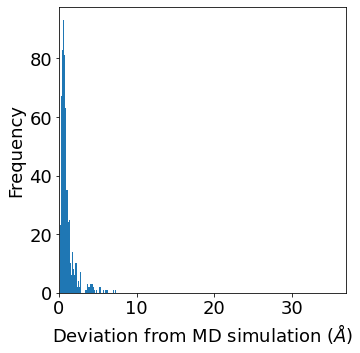

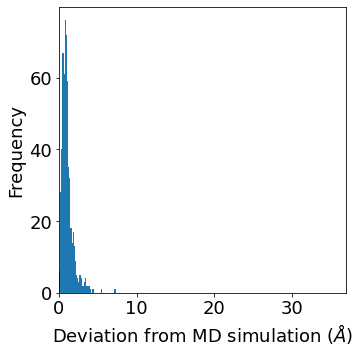

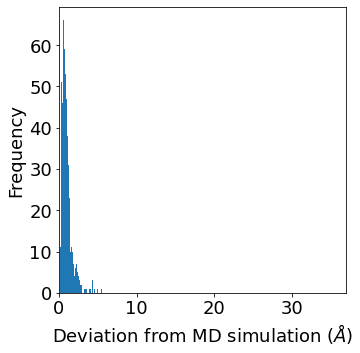

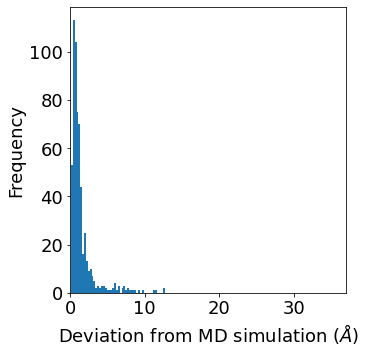

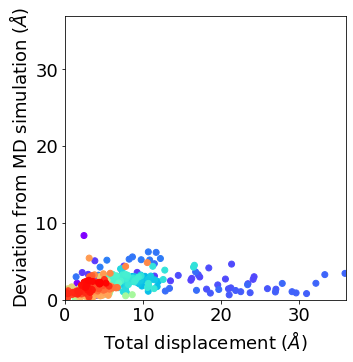

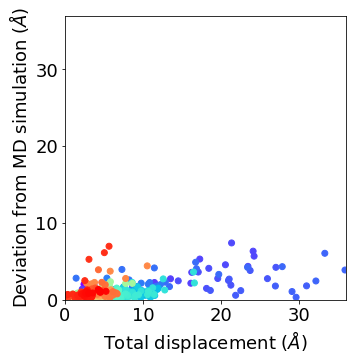

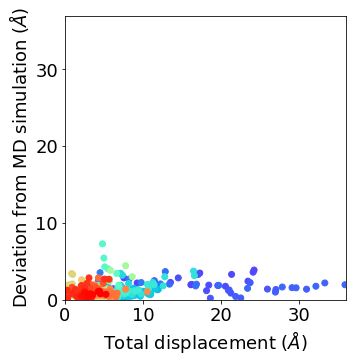

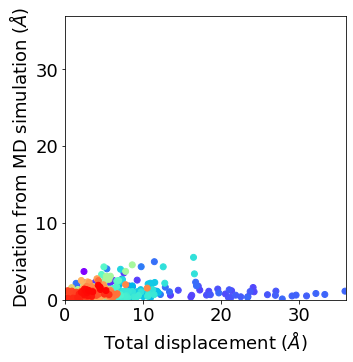

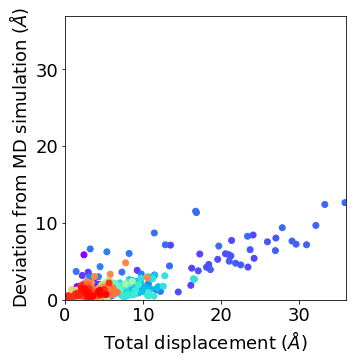

In [31]:
d_T_r = torch.sqrt(torch.sum((mdt_r - mdt) ** 2, -1))

# max_error = int(torch.max(d_T_r)) + 1
max_displacement = int(torch.max(d_total)) + 1

num_figs = 5
fig_size = 21 # cm
for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    ax = plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.hist(d_T_r[g_ind][None], bins=50)
    plt.xlim([0, max_error])
    plt.ylabel('Frequency')
    plt.xlabel(r'Deviation from MD simulation ($\AA$)')
plt.show()

for i in range(num_figs):
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    md_ind = int(i/(num_figs-1) * (num_proteins-1))
    plt.figure(figsize=(fig_size/4, fig_size/4))
    plt.scatter(d_total,d_T_r[g_ind], c = torch.linspace(0,1,protein_len), cmap = 'rainbow')
    plt.ylim([0, max_error])
    plt.xlim([0, max_displacement])
    plt.xlabel(r'Total displacement ($\AA$)')
    plt.ylabel(r'Deviation from MD simulation ($\AA$)')
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_displacement_vs_error_rank_{rank}_md_{md_ind}'+formt))
plt.show()

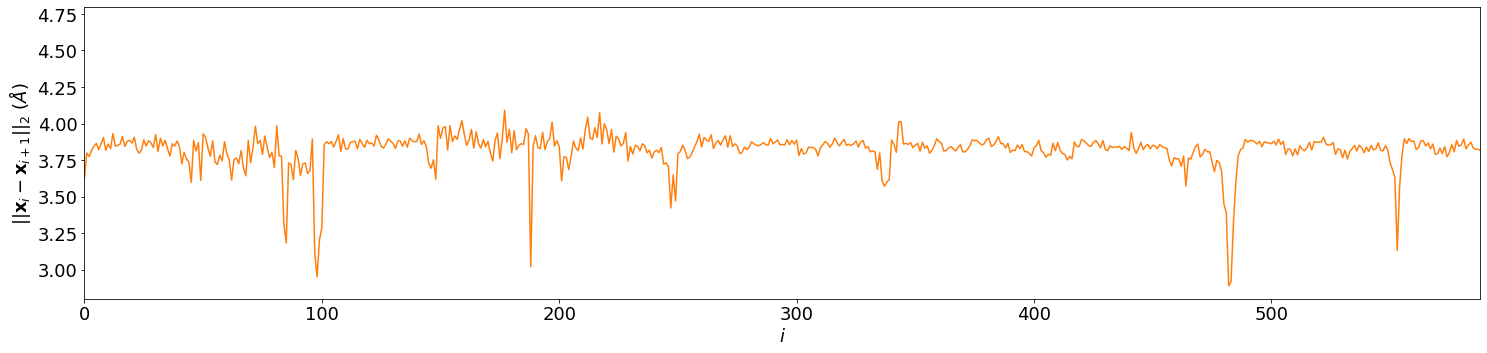

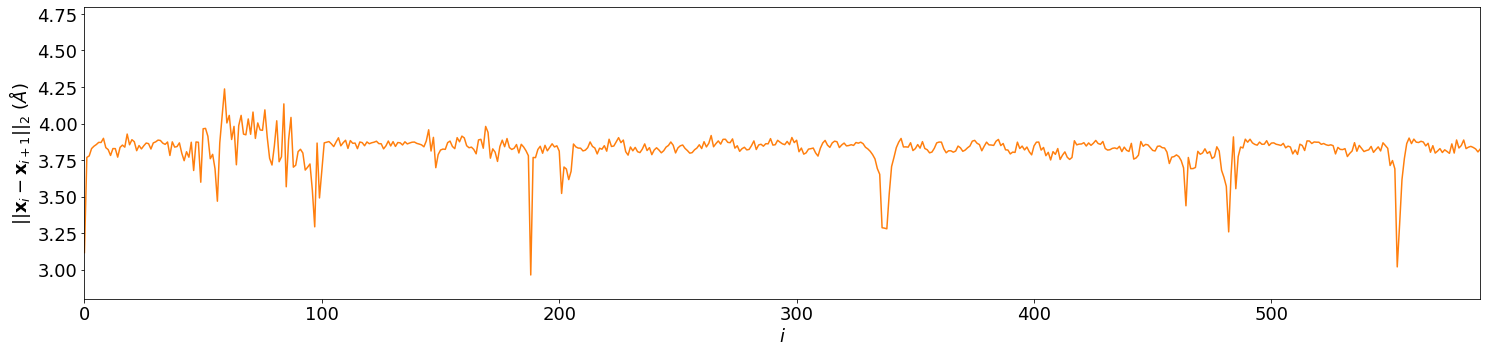

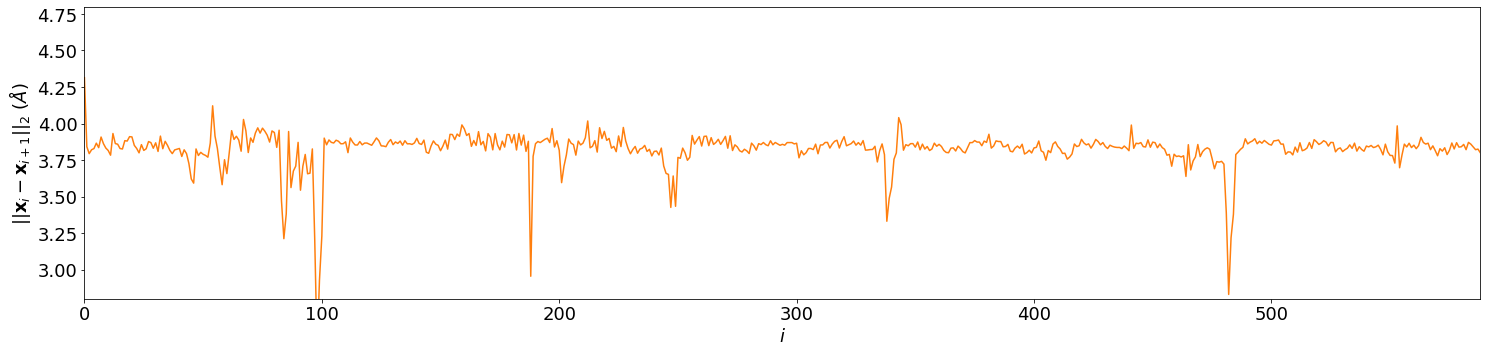

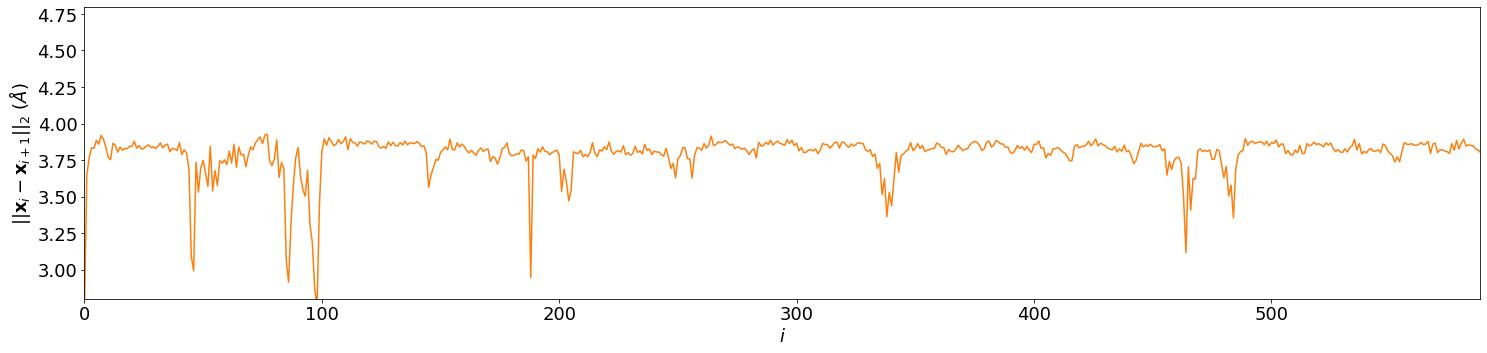

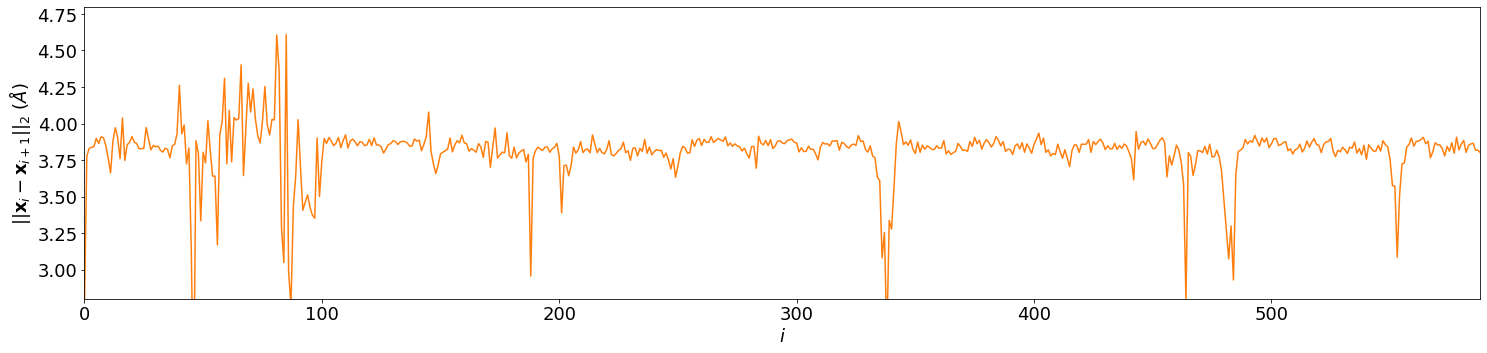

In [32]:
mdt_r_pairwise_distances = manifold.pairwise_distances(mdt_r[None]).squeeze()
mdt_r_adj_pairwise_distances = torch.diagonal(mdt_r_pairwise_distances,offset=1, dim1=1, dim2=2)

num_figs = 5
fig_size = 21 # cm

for i in range(num_figs):
    plt.figure(figsize=(fig_size, fig_size/4))
    g_ind = int(i/(num_figs-1) * (t_steps-1))
    plt.plot(range(protein_len-1), torch.sqrt(mdt_r_adj_pairwise_distances[g_ind]), color='tab:orange')
    plt.xlim([0, protein_len-2])
    plt.ylim([2.8,4.8])
    plt.ylabel(r'$\|\|\mathbf{x}_i - \mathbf{x}_{i+1}\|\|_2$ ($\AA$)')
    plt.xlabel(r'$i$')
    # save figure
    plt.savefig(os.path.join(results_folder,fig_prefix +f'_adjacent_residue_{g_ind}f{t_steps-1}_mdt_r_rank_{rank}'+formt)) 
plt.show()

## Stability with respect to curvature ##

In [21]:
# so first we want to do geodesic variation
# start from different starting points in the data and go to same end
v_index = 3
pt_v0 = torch.zeros(t_steps, protein_len, 3)
pt_v1 = torch.zeros(t_steps, protein_len, 3)
p0_v = proteins[v_index]
p1_v = proteins[-1 - v_index]
for i,t in enumerate(T):
    print(f"computing geodesic {i+1} of variation {v_index}")
    pt_v0[i] = manifold.s_geodesic(p0_v[None,None], p1[None,None], torch.tensor([t]), debug=True).squeeze()
    pt_v1[i] = manifold.s_geodesic(p0[None,None], p1_v[None,None], torch.tensor([t]), debug=True).squeeze()

computing geodesic 1 of variation 3
1 | relerror = 0.9382236003875732
2 | relerror = 0.37542957067489624
3 | relerror = 0.15003465116024017
4 | relerror = 0.06674253940582275
5 | relerror = 0.05405788868665695
6 | relerror = 0.018719317391514778
7 | relerror = 0.0021385946311056614
8 | relerror = 1.7135167581727728e-05
1 | relerror = 1.1221840381622314
2 | relerror = 0.48827385902404785
3 | relerror = 0.09374434500932693
4 | relerror = 0.00527371047064662
5 | relerror = 5.045218495070003e-05
computing geodesic 2 of variation 3
1 | relerror = 0.8918286561965942
2 | relerror = 0.3369751274585724
3 | relerror = 0.1304815411567688
4 | relerror = 0.05516389384865761
5 | relerror = 0.04248994216322899
6 | relerror = 0.034220945090055466
7 | relerror = 0.01808266155421734
8 | relerror = 0.0020185725297778845
9 | relerror = 3.486048444756307e-05
1 | relerror = 1.0584073066711426
2 | relerror = 0.44540464878082275
3 | relerror = 0.07913096249103546
4 | relerror = 0.004674618132412434
5 | relerr

5 | relerror = 0.0034031348768621683
6 | relerror = 0.0024560282472521067
7 | relerror = 0.0017937262309715152
8 | relerror = 0.0013137704227119684
9 | relerror = 0.0009630106505937874
1 | relerror = 0.3977450430393219
2 | relerror = 0.08700580149888992
3 | relerror = 0.008527686819434166
4 | relerror = 0.003869705367833376
5 | relerror = 0.002299647545441985
6 | relerror = 0.0015400855336338282
7 | relerror = 0.0010859848698601127
8 | relerror = 0.0007800981984473765
computing geodesic 14 of variation 3
1 | relerror = 0.3233642578125
2 | relerror = 0.05912470817565918
3 | relerror = 0.006741544231772423
4 | relerror = 0.0028336304239928722
5 | relerror = 0.0016594730550423265
6 | relerror = 0.0010625014547258615
7 | relerror = 0.0006980905309319496
1 | relerror = 0.3440611958503723
2 | relerror = 0.0667467713356018
3 | relerror = 0.0056034778244793415
4 | relerror = 0.002245581243187189
5 | relerror = 0.00109867041464895
6 | relerror = 0.0005804214160889387
computing geodesic 15 of va

<function matplotlib.pyplot.show(close=None, block=None)>

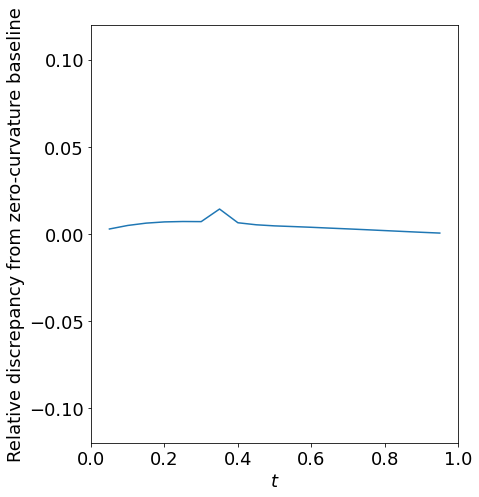

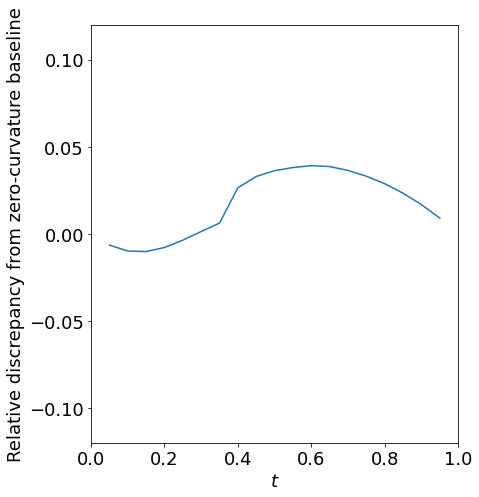

In [33]:
# compute RMSD in Anstrom for geodesics vs trajectory
rmsd_T_v0 = torch.sqrt(torch.sum((pt - pt_v0) ** 2,[1,2]) / protein_len)
rmsd_T_v1 = torch.sqrt(torch.sum((pt - pt_v1) ** 2,[1,2]) / protein_len)

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/3, fig_size/3))
plt.plot(T[1:-1], (rmsd_T_v0 - (1 - T)*rmsd_T_v0[0])[1:-1]/rmsd_T_v0[0])
plt.xlim([0,1])
plt.ylim([-0.12,0.12])
plt.xlabel(r'$t$')
plt.ylabel(r'Relative discrepancy from zero-curvature baseline')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_v0'+formt))
plt.show

# plot 
fig_size = 21 # cm
plt.figure(figsize=(fig_size/3, fig_size/3))
plt.plot(T[1:-1], (rmsd_T_v1 - T*rmsd_T_v1[-1])[1:-1]/rmsd_T_v1[-1])
plt.xlim([0,1])
plt.ylim([-0.12,0.12])
plt.xlabel(r'$t$')
plt.ylabel(r'Relative discrepancy from zero-curvature baseline')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_progression_v1'+formt))
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

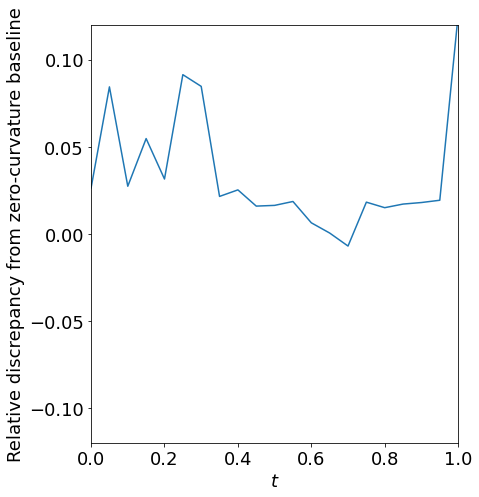

In [34]:
trmsd_T_r = torch.sqrt(torch.sum((log_p_barycentre_t_r - log_p_barycentre_t) ** 2,[1,2]) / protein_len)
trmsd_T_r_0 = torch.sqrt(torch.sum(log_p_barycentre_t ** 2,[1,2]) / protein_len)

fig_size = 21 # cm
plt.figure(figsize=(fig_size/3, fig_size/3))
plt.plot(T, (rmsd_T_r - trmsd_T_r)/trmsd_T_r_0)
plt.xlim([0,1])
plt.ylim([-0.12,0.12])
plt.xlabel(r'$t$')
plt.ylabel(r'Relative discrepancy from zero-curvature baseline')
# save figure
plt.savefig(os.path.join(results_folder,fig_prefix +f'_RMSD_and_TRMSD_progression_rank_{rank}'+formt))
plt.show